# T.U.I.A 2024 - Aprendizaje Automático II
## TP 2 - Redes Recurrentes
## Integrantes:
* Ponce, Daniel
* Yañez, Mirian

## Problema 1 - Detección de idioma

Descripción:

En este problema, se presenta un conjunto de datos que contiene clips de audio correspondientes a oraciones habladas en distintos idiomas.

Dataset:
https://www.tensorflow.org/datasets/catalog/xtreme_s


El dataset proporcionado incluye diversos sub-datasets correspondientes a oraciones habladas en distintos idiomas. Utilizaremos un subconjunto de estos datasets para entrenar un clasificador de idiomas hablados.

Objetivo:

Utilizando el dataset proporcionado, el objetivo es construir un modelo de clasificación utilizando redes neuronales que pueda inferir el idioma correspondiente.


Como paso preliminar, se solicita construir un dataset de clasificación utilizando los siguientes idiomas del set de datos:

Español: https://www.tensorflow.org/datasets/catalog/xtreme_s#xtreme_sfleurses_419

Inglés: https://www.tensorflow.org/datasets/catalog/xtreme_s#xtreme_sfleursen_us

Francés: https://www.tensorflow.org/datasets/catalog/xtreme_s#xtreme_sfleursfr_fr

Japonés: https://www.tensorflow.org/datasets/catalog/xtreme_s#xtreme_sfleursja_jp

Se solicita entrenar dos modelos de distintas arquitecturas y comparar los resultados:

Modelo convolucional sobre los espectrogramas de los clips.

Modelo recurrente sobre los espectrogramas de los clips.

Ver https://colab.research.google.com/github/FCEIA-AAII/lab11/blob/master/lab11-a.ipynb como ejemplo de obtención de espectrogramas a partir de clips de audio.

Entrega:

La entrega debe incluir:

Código fuente de la solución implementada en Google Colab, que incluya:

Análisis previo y preprocesamiento del set de datos.
Definición y entrenamiento del modelo.

Resultados de la evaluación de los modelos, incluyendo métricas de desempeño y visualizaciones relevantes.

Nota: el código debe estar debidamente documentado con comentarios explicativos para que el trabajo sea fácilmente comprensible para otros revisores.

## Instalamos las dependencias

In [1]:
!pip install pydub
!pip install tensorflow

## Conectamos Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import random
import logging
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from typing import Tuple, Dict
import matplotlib.pyplot as plt
logging.basicConfig(level=logging.INFO)

## Definimos la clase 'DatasetPreparator', para dividir en entrenamiento, validación y prueba, generando archivos de anotaciones necesarios para entrenar modelos

In [4]:
class DatasetPreparator:
    def __init__(self, source_dir: str, annotation_dir: str) -> None:
        self.source_dir = source_dir
        self.annotation_dir = annotation_dir

    def generate_annotations(self, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1) -> Dict[str, int]:
        os.makedirs(self.annotation_dir, exist_ok=True)
        label_mapping = {}
        train_file = open(os.path.join(self.annotation_dir, "train.txt"), "w")
        val_file = open(os.path.join(self.annotation_dir, "val.txt"), "w")
        test_file = open(os.path.join(self.annotation_dir, "test.txt"), "w")

        print("Generando anotaciones...")

        for idx, class_name in enumerate(os.listdir(self.source_dir)):
            class_path = os.path.join(self.source_dir, class_name)
            if not os.path.isdir(class_path):
                logging.warning(f"{class_path} no es un directorio. Se omitirá.")
                continue

            label_mapping[class_name] = idx
            files = os.listdir(class_path)
            random.shuffle(files)

            total_files = len(files)
            train_count = int(total_files * train_ratio)
            val_count = int(total_files * val_ratio)

            train_files = files[:train_count]
            val_files = files[train_count:train_count + val_count]
            test_files = files[train_count + val_count:]

            for file_name in train_files:
                train_file.write(f"{os.path.join(class_path, file_name)} {idx}\n")
            for file_name in val_files:
                val_file.write(f"{os.path.join(class_path, file_name)} {idx}\n")
            for file_name in test_files:
                test_file.write(f"{os.path.join(class_path, file_name)} {idx}\n")

            print(f"Clase {class_name}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

        train_file.close()
        val_file.close()
        test_file.close()
        print("Anotaciones generadas correctamente.")
        return label_mapping

## Definimos la clase 'DatasetProcessor', para cargar anotaciones, procesar archivos de audio, generar espectrogramas y preparar datos necesarios para entrenar modelos.


In [5]:
class DatasetProcessor:
    def __init__(self, annotation_file: str) -> None:
        self.annotation_file = annotation_file

    @staticmethod
    def preprocess_audio(audio_path: str) -> np.ndarray:
        audio = tf.io.read_file(audio_path)
        audio, _ = tf.audio.decode_wav(audio)
        audio = tf.squeeze(audio, axis=-1)
        audio = tf.cast(audio, tf.float32)

        # Generar el espectrograma
        stft = tf.signal.stft(audio, frame_length=256, frame_step=128)
        spectrogram = tf.abs(stft)

        # Normalizar el espectrograma
        spectrogram = tf.math.log1p(spectrogram)

        # Asegurarse de que tenga la forma correcta (alto, ancho, canal)
        spectrogram = tf.expand_dims(spectrogram, axis=-1)
        spectrogram = tf.image.resize(spectrogram, [128, 128]).numpy()

        return spectrogram

    def load_data(self) -> Tuple[np.ndarray, np.ndarray]:
        spectrograms = []
        labels = []

        print(f"Cargando datos desde {self.annotation_file}...")

        try:
            with open(self.annotation_file, "r") as file:
                for line in file:
                    audio_path, label = line.strip().split()
                    try:
                        spectrogram = self.preprocess_audio(audio_path)
                        spectrograms.append(spectrogram)
                        labels.append(int(label))
                    except Exception as e:
                        logging.error(f"Error procesando {audio_path}: {e}")

            print(f"Datos cargados correctamente: {len(spectrograms)} muestras.")
            return np.array(spectrograms), np.array(labels)
        except Exception as e:
            logging.error(f"Error cargando datos: {e}")
            raise

## Definimos la clase 'ModelTrainer', para crear modelos CNN y RNN, entrenar con conjuntos de datos, evaluar rendimiento y visualizar métricas de entrenamiento.

In [6]:
class ModelTrainer:
    def __init__(self, input_shape: Tuple[int, int, int], num_classes: int) -> None:
        self.input_shape = input_shape
        self.num_classes = num_classes

    def create_cnn_model(self) -> models.Sequential:
        model = models.Sequential([
            layers.Input(shape=self.input_shape),
            # Primera capa convolucional
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),

            # Segunda capa convolucional
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),

            # Tercera capa convolucional
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),

            # Cuarta capa convolucional
            layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),

            # Aplanar y capas densas
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),  # Regularización
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),  # Regularización
            # Capa de salida
            layers.Dense(self.num_classes, activation='softmax')
        ])

        # Compilación del modelo
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    def create_rnn_model(self) -> models.Sequential:
        """
        Crea un modelo RNN puro que trabaja directamente sobre los espectrogramas tratados como secuencias temporales.

        Returns:
            models.Sequential: Modelo RNN compilado.
        """
        model = models.Sequential([
            layers.Input(shape=(self.input_shape[0], self.input_shape[1])),
            layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
            layers.Bidirectional(layers.LSTM(128)),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),  # Regularización para evitar sobreajuste
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax')
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    @staticmethod
    def plot_metrics(history):
        acc = history['accuracy']
        val_acc = history['val_accuracy']
        loss = history['loss']
        val_loss = history['val_loss']

        epochs = range(1, len(acc) + 1)

        plt.figure()
        plt.plot(epochs, acc, 'b', label='Entrenamiento')
        plt.plot(epochs, val_acc, 'r', label='Validación')
        plt.title('Precisión en entrenamiento y validación')
        plt.legend()
        plt.show()

        plt.figure()
        plt.plot(epochs, loss, 'b', label='Entrenamiento')
        plt.plot(epochs, val_loss, 'r', label='Validación')
        plt.title('Pérdida en entrenamiento y validación')
        plt.legend()
        plt.show()

    def train_and_evaluate(self, model, train_ds, val_ds, test_ds, epochs=10):
        try:
            print("Comenzando el entrenamiento...")
            history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)
            history_dict = history.history
            test_loss, test_accuracy = model.evaluate(test_ds)
            print(f"Entrenamiento completado. Precisión en prueba: {test_accuracy:.4f}")
            self.plot_metrics(history_dict)
            return history_dict, test_loss, test_accuracy
        except Exception as e:
            logging.error(f"Error durante el entrenamiento o evaluación: {e}")
            raise

## Definimos las variables que especifican el directorio fuente de datos y el destino de las anotaciones generadas.


In [7]:
source_dir = "/content/drive/MyDrive/dataset_reducido"
annotation_dir = "annotationss"

# Armado De Dataset

In [8]:
preparator = DatasetPreparator(source_dir, annotation_dir)
label_mapping = preparator.generate_annotations()
print(f"Etiquetas generadas: {label_mapping}")

# Procesar datos
train_processor = DatasetProcessor(os.path.join(annotation_dir, "train.txt"))
val_processor = DatasetProcessor(os.path.join(annotation_dir, "val.txt"))
test_processor = DatasetProcessor(os.path.join(annotation_dir, "test.txt"))

train_images, train_labels = train_processor.load_data()
val_images, val_labels = val_processor.load_data()
test_images, test_labels = test_processor.load_data()

print(f"Tamaños de datasets - Train: {len(train_images)}, Val: {len(val_images)}, Test: {len(test_images)}")

Generando anotaciones...
Clase español: 160 train, 20 val, 20 test
Clase ingles: 160 train, 20 val, 20 test
Clase frances: 160 train, 20 val, 20 test
Clase japones: 160 train, 20 val, 20 test
Anotaciones generadas correctamente.
Etiquetas generadas: {'español': 0, 'ingles': 1, 'frances': 2, 'japones': 3}
Cargando datos desde annotationss/train.txt...
Datos cargados correctamente: 640 muestras.
Cargando datos desde annotationss/val.txt...
Datos cargados correctamente: 80 muestras.
Cargando datos desde annotationss/test.txt...
Datos cargados correctamente: 80 muestras.
Tamaños de datasets - Train: 640, Val: 80, Test: 80


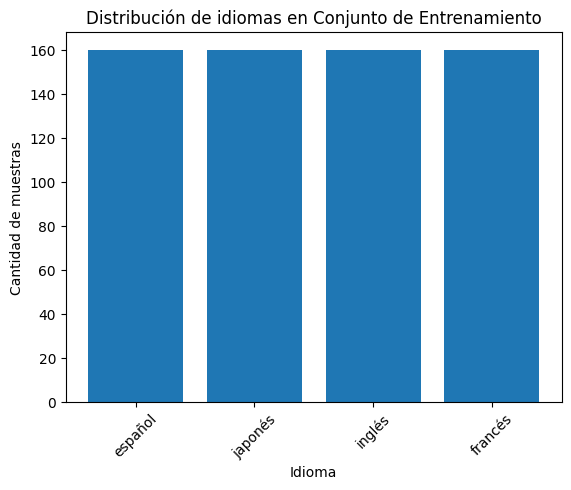

Distribución en Conjunto de Entrenamiento:
español: 160 muestras (25.00%)
japonés: 160 muestras (25.00%)
inglés: 160 muestras (25.00%)
francés: 160 muestras (25.00%)



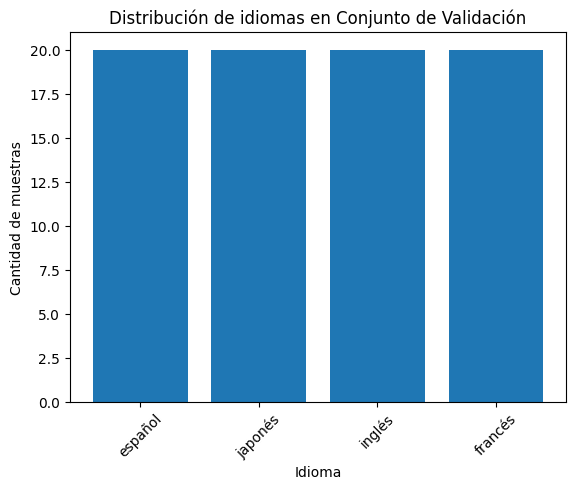

Distribución en Conjunto de Validación:
español: 20 muestras (25.00%)
japonés: 20 muestras (25.00%)
inglés: 20 muestras (25.00%)
francés: 20 muestras (25.00%)



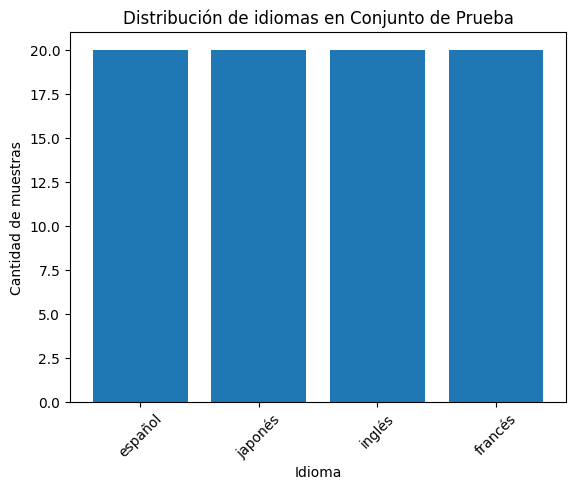

Distribución en Conjunto de Prueba:
español: 20 muestras (25.00%)
japonés: 20 muestras (25.00%)
inglés: 20 muestras (25.00%)
francés: 20 muestras (25.00%)



In [9]:
import matplotlib.pyplot as plt
from collections import Counter

def analyze_distribution(labels, dataset_name):
    # Contar la cantidad de etiquetas por idioma
    label_counts = Counter(labels)

    # Mapear índices a nombres de idiomas
    label_mapping = {0: 'español', 1: 'japonés', 2: 'inglés', 3: 'francés'}
    label_counts_named = {label_mapping[k]: v for k, v in label_counts.items()}

    # Visualizar la distribución
    plt.bar(label_counts_named.keys(), label_counts_named.values())
    plt.title(f"Distribución de idiomas en {dataset_name}")
    plt.xlabel("Idioma")
    plt.ylabel("Cantidad de muestras")
    plt.xticks(rotation=45)
    plt.show()

    # Calcular porcentaje de cada idioma
    total = sum(label_counts.values())
    percentages = {lang: (count / total) * 100 for lang, count in label_counts_named.items()}

    # Mostrar los resultados
    print(f"Distribución en {dataset_name}:")
    for lang, count in label_counts_named.items():
        print(f"{lang}: {count} muestras ({percentages[lang]:.2f}%)")
    print()

# Analizar distribución en cada conjunto
analyze_distribution(train_labels, "Conjunto de Entrenamiento")
analyze_distribution(val_labels, "Conjunto de Validación")
analyze_distribution(test_labels, "Conjunto de Prueba")


Podemos observar que los conjuntos de entrenamiento, validación y prueba están balanceados, con una distribución uniforme de idiomas (25% para cada uno: español, japonés, inglés y francés). Esto es beneficioso porque evita sesgos en el aprendizaje del modelo, permitiendo que todas las clases tengan la misma representación. Esto puede indicar que el modelo puede generalizar mejor y tener un desempeño consistente en todas las clases. Además, al evaluar el modelo, las métricas reflejan un rendimiento más justo y preciso, ya que no se favorece a ninguna clase en particular.

## Validamos los datos cargados y preparamos los datasets

In [10]:
if len(train_images) == 0 or len(val_images) == 0 or len(test_images) == 0:
    logging.error("No se encontraron datos en los datasets. Verifica las rutas y anotaciones.")
    exit(1)

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

print("Datos preparados. Iniciando la creación del modelo...")
trainer = ModelTrainer(input_shape=(128, 128, 1), num_classes=len(label_mapping))

Datos preparados. Iniciando la creación del modelo...


# Modelo CNN

Comenzando el entrenamiento...
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - accuracy: 0.3982 - loss: 5.0026 - val_accuracy: 0.2500 - val_loss: 1.4028
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.1695 - loss: 4.3121 - val_accuracy: 0.2500 - val_loss: 1.5459
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2552 - loss: 2.0047 - val_accuracy: 0.2500 - val_loss: 1.7712
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3128 - loss: 1.4169 - val_accuracy: 0.2500 - val_loss: 2.0083
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3829 - loss: 1.3308 - val_accuracy: 0.2500 - val_loss: 2.1768
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4549 - loss: 1.2375 - val_accuracy: 0.2500 - val_loss: 2.2274
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4930 - loss: 1.1940 - val_accuracy: 0.2500 - val_loss: 2.2012
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4195

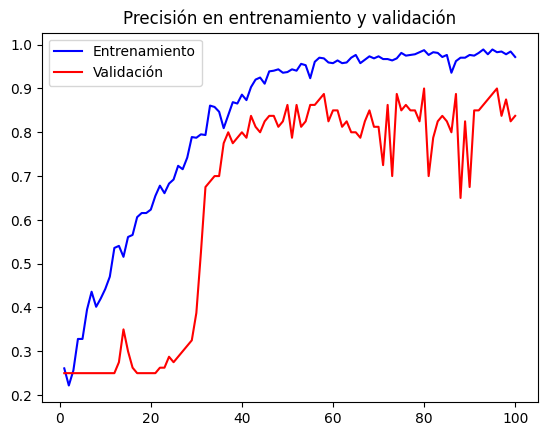

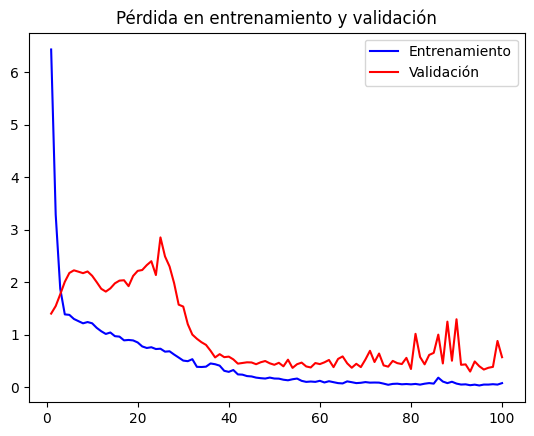

In [11]:
cnn_model = trainer.create_cnn_model()
history, test_loss, test_accuracy = trainer.train_and_evaluate(
    cnn_model, train_ds, val_ds, test_ds, epochs=100
)

El entrenamiento muestra una alta precisión en el conjunto de entrenamiento, superando el 98%, mientras que la precisión en el conjunto de validación es notablemente inferior y fluctuante, lo que indica un posible sobreajuste. Esto se refleja claramente en los gráficos, donde la precisión en entrenamiento crece de manera constante y estable, mientras que en la validación presenta variaciones significativas y una menor estabilidad.

Las curvas de pérdida refuerzan este análisis, mostrando una disminución progresiva y controlada en el entrenamiento, pero con fluctuaciones importantes en la validación, evidenciando una sensibilidad del modelo a la distribución de los datos de prueba. Aunque el modelo aprende bien los patrones del conjunto de entrenamiento, estos resultados sugieren que su capacidad para generalizar aún no es óptima.

# Modelo RNN

Comenzando el entrenamiento...
Epoch 1/220
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.2598 - loss: 1.3912 - val_accuracy: 0.2875 - val_loss: 1.3790
Epoch 2/220
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4504 - loss: 1.3654 - val_accuracy: 0.3500 - val_loss: 1.3727
Epoch 3/220
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4920 - loss: 1.3629 - val_accuracy: 0.3875 - val_loss: 1.3658
Epoch 4/220
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4439 - loss: 1.3587 - val_accuracy: 0.3750 - val_loss: 1.3582
Epoch 5/220
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4119 - loss: 1.3529 - val_accuracy: 0.3750 - val_loss: 1.3471
Epoch 6/220
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3953 - loss: 1.3433 - val_accuracy: 0.3750 - val_loss: 1.3363
Epoch 7/220
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4224 - loss: 1.3301 - val_accuracy: 0.3750 - val_loss: 1.3211
Epoch 8/220
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4156 - 

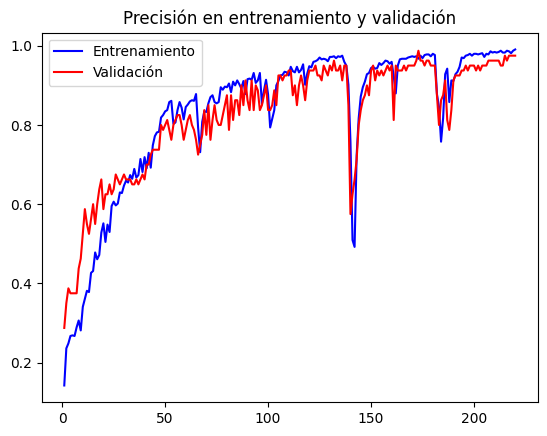

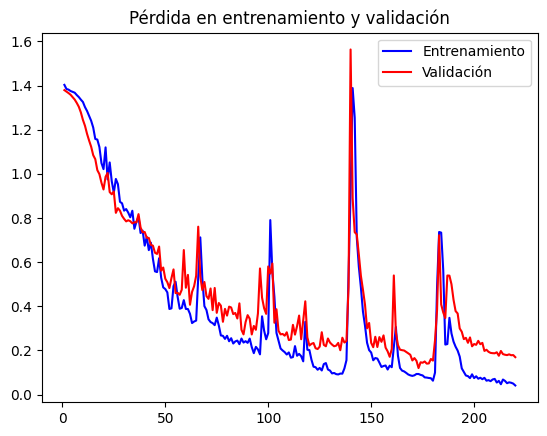

In [12]:
rnn_model = trainer.create_rnn_model()
history, test_loss, test_accuracy = trainer.train_and_evaluate(
    rnn_model, train_ds, val_ds, test_ds, epochs=220
)

El entrenamiento del modelo muestra un desempeño sólido, alcanzando una precisión de prueba del 95.00%. Las curvas de precisión y pérdida reflejan un comportamiento estable entre el entrenamiento y la validación, lo que indica una buena capacidad de generalización.

En las métricas de precisión, tanto el conjunto de entrenamiento como el de validación mantienen una tendencia ascendente, convergiendo hacia valores altos con mínima divergencia entre ambos. En cuanto a la pérdida, esta disminuye de manera consistente en entrenamiento y validación, aunque con ligeras oscilaciones en la validación, que no afectan significativamente el desempeño global del modelo.

Estos resultados sugieren que el modelo está bien ajustado a los datos, logrando minimizar la pérdida y alcanzar un equilibrio entre aprender los patrones del conjunto de entrenamiento y generalizar correctamente en datos no vistos.

# Conclusión

El cambio en la precisión al pasar de redes neuronales convolucionales (CNN) a redes neuronales recurrentes (RNN) en este problema es notable y refuerza la idea de que las RNN son más adecuadas para tareas donde la secuencialidad de los datos es un factor determinante. Inicialmente, con las CNN, logramos una precisión en el conjunto de prueba de 77.50%. Este resultado refleja la capacidad de las CNN para identificar patrones espaciales locales en los datos, como en imágenes o espectrogramas, donde las características están relacionadas principalmente por su proximidad espacial. Sin embargo, las CNN no están diseñadas para capturar dependencias temporales, lo que limita su desempeño en problemas que requieren modelar relaciones entre pasos consecutivos en los datos.

Al entrenar el modelo basado en RNN, alcanzamos una precisión significativamente mayor del 95.00% en el conjunto de prueba. Este incremento subraya la ventaja de las RNN en capturar patrones temporales y modelar la dinámica inherente en los datos secuenciales. Las RNN, especialmente en variantes avanzadas como las bidireccionales o aquellas con celdas de memoria (LSTM o GRU), permiten al modelo aprender dependencias tanto hacia adelante como hacia atrás en la secuencia, proporcionando una comprensión más completa de los datos. En este contexto, las RNN se destacaron al permitir que el modelo analice cómo las características evolucionan y se relacionan en el tiempo, una capacidad crucial para resolver este problema.

El aumento en la precisión evidencia que las RNN están mejor equipadas para generalizar en tareas que requieren el análisis temporal, evitando las limitaciones que las CNN presentan en este aspecto.